# Scheffel HW 2

# Honor Pledge

On my honor, I pledge that I have neither given nor received help on this assignment.

In [1]:
# import libraries

import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style = "ticks")
from itertools import combinations

In [2]:
# load data sets

wine_training = pd.read_csv("whitewine-training-ds6040.csv")
wine_testing = pd.read_csv("whitewine-testing-ds6040.csv")

In [3]:
# LDA Class (code given in example from Professor)

class LDA():
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors =  np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        self.sigma = dataset.cov()
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = self.sigma))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 
    def predict_MAP(self, data = None):        
        if data is None:
            data = self.training_data
        dens_list = self.predict_probs(data).drop('True Class', axis = 1)
        map_list = dens_list.idxmax(axis = 1)
        maps = {'MAP Class': map_list}
        maps = pd.DataFrame(maps)
        maps['True Class'] = data[self.class_var]
        return maps
    def misclass_rate(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        
        maps['Mis_class'] = maps['MAP Class']  == maps['True Class']
        
        mis_class =  1 - maps['Mis_class'].mean()
        
        return mis_class
    def misclass_xtabs(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        
        xtabs = pd.crosstab(maps['MAP Class'], maps['True Class'])        
        return xtabs
    def misclass_pairplot(self, data = None):
        if data is None:
            data = self.training_data
        maps = self.predict_MAP(data = data)
        temp_dat = data.copy(deep = True)
        temp_dat['Mis-Classified'] = maps['MAP Class']  != maps['True Class']
        plot = sns.pairplot(temp_dat,hue="Mis-Classified", height = 1.5, aspect = 1.5)   
        return plot

# 1. Linear Discriminant Analysis (25 Points) After loading your training data, fit LDA classifiers (using all 11 continuous features to predict wine quality) under the following scenarios

In each case, calculate the overall mis-classification rate and present a cross-tabs table showing which categories are being classified correctly vs. incorrectly in your training dataset. (Note, do not present pair-plots here, the dimensionality is too high.)
Next, for each prior, apply your LDA model to the testing dataset, and present the mis-classification rate and cross-tabs.
Discuss the performance of your LDA models under your various choices of priors. How does the performance change when we start testing our models on the testing data?

# (a) Non-informative (flat) priors on wine quality

In [4]:
# default uniform priors
LDA_wine_flat = LDA(wine_training, 'wine_quality')

# misclassification rate of training set
LDA_wine_flat.misclass_rate()

0.49496538703587156

The wine training set misclassification rate is 49.50%.

In [5]:
# cross-tabs table
LDA_wine_flat.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,69,687,62
C,22,800,202
F,9,591,736


In [6]:
# misclassification of testing set
LDA_wine_flat.misclass_rate(data = wine_testing)

0.48546511627906974

The wine testing set misclassification rate is 48.55%.

In [7]:
# cross-tabs table
LDA_wine_flat.misclass_xtabs(data = wine_testing)

True Class,A,C,F
MAP Class,,,
A,56,348,43
C,15,381,149
F,9,271,448


# (b) Priors that reflect the observed proportion of wines at different quality levels.

In [8]:
wine_quality = wine_training['wine_quality'].value_counts(normalize = True) 

wine_quality

C    0.653870
F    0.314663
A    0.031466
Name: wine_quality, dtype: float64

In [9]:
priors_observed = [wine_quality[2], wine_quality[0], wine_quality[1] ]
LDA_wine_observed = LDA(wine_training, 'wine_quality', priors_observed)

In [10]:
# misclassification of training set
LDA_wine_observed.misclass_rate()

0.28099433606041535

The wine training set misclassification rate is 28.10%.

In [11]:
# cross-tabs table
LDA_wine_observed.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,0,0,1
C,100,1913,627
F,0,165,372


In [12]:
# misclassification of testing set
LDA_wine_observed.misclass_rate(data = wine_testing)

0.32732558139534884

The wine testing set misclassification rate is 32.73%.

In [13]:
# cross-tabs table
LDA_wine_observed.misclass_xtabs(data = wine_testing)

True Class,A,C,F
MAP Class,,,
C,79,923,406
F,1,77,234


# (c) Priors that reflect the notion that most wines are awful, some wines are average, and few wines are good (your choice for specific values.)

In [14]:
LDA_wine_mix = LDA(wine_training, 'wine_quality', [.05, .20, .75])

In [15]:
LDA_wine_mix.misclass_rate()

0.5821271239773442

The wine training set misclassification rate is 58.21%.

In [16]:
LDA_wine_mix.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,8,29,3
C,38,337,14
F,54,1712,983


In [17]:
LDA_wine_mix.misclass_rate(data = wine_testing)

0.5226744186046511

The wine testing set misclassification rate is 52.27%.

In [18]:
LDA_wine_mix.misclass_xtabs(data = wine_testing)

True Class,A,C,F
MAP Class,,,
A,8,21,0
C,21,185,12
F,51,794,628


# (d) Priors that somebody with terrible taste in wine would use (i.e. most wines are good, few wines are bad or average).

In [19]:
LDA_wine_terrible = LDA(wine_training, 'wine_quality', [.85, .10, .05])

In [20]:
LDA_wine_terrible.misclass_rate()

0.9222781623662681

The wine training set misclassification rate is 92.23%.

In [21]:
LDA_wine_terrible.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,100,2045,848
C,0,0,5
F,0,33,147


In [22]:
LDA_wine_terrible.misclass_rate(data = wine_testing)

0.9052325581395348

The wine testing set misclassification rate is 90.52%.

In [23]:
LDA_wine_terrible.misclass_xtabs(data = wine_testing)

True Class,A,C,F
MAP Class,,,
A,79,974,552
C,0,0,4
F,1,26,84


# Discuss the performance of your LDA models under your various choices of priors. How does the performance change when we start testing our models on the testing data?

Among the four LDA models, they exhibit varying misclassification rates. The model employing proportional priors demonstrates superior performance, with around 30% of the data being misclassified.
The model utilizing non-informed priors ranks as the second-best, although roughly half of the data is misclassified.
The model assigning most wines as poor performs third best, misclassifying 49.5% of the training data and 48.5% of the testing data. The model representing someone with a bad taste in wine misclassifies almost all of the data. Interestingly, despite using mirrored proportions for the classifications of 'Good Taste' and 'Bad Taste,' the 'Good Taste' model still underperforms, whereas the 'Bad Taste' model misclassifies nearly all data points.

Given the significant class imbalance in wine quality, I would recommend employing proportional priors. This approach enables the model to better handle the imbalanced classes and make more accurate predictions.

Analyzing the performance change when testing the models on testing data:
When testing the models on the testing data, the accuracy of the uninformed, good taste, and bad taste priors increases. Conversely, the accuracy of the model with proportional priors decreases.
This phenomenon can be attributed to the fact that the proportions used for the priors are directly tied to the training data, while the proportions in the testing data may differ. On the other hand, the other priors do not rely explicitly on a metric from the training data. Nevertheless, these priors still outperform the other models significantly.

# 2. (25 Points) Fit LDA models for each combination of 3 features (loop over all combinations of 3 features, there will be 165 combinations). Use flat priors on wine quality.

(a) For each model, extract the overall miss-classification rate for both the training and the testing dataset. Which combination of three features provides the lowest miss-classification rate for the testing and training datasets? Are they the same or different (between the training/testing)? For the best performing models (for training and testing), using the functions provided, provide pair-plots for mis-classification.

In [70]:
# loop over all combinations of 3 features, there will be 165 combinations
def three_features_combo(priors):
    features_combo = [list(x) for x in combinations(wine_training.drop('wine_quality', axis = 1), 3)]

    LDA_training_results = []
    LDA_testing_results = []

    # iterate combos 
    for combination in features_combo:
        current_columns = combination + ['wine_quality']
        train_three = wine_training[current_columns]
        test_three = wine_testing[current_columns]
        LDA_3 = LDA(train_three, 'wine_quality', priors = priors)
        train_misclass = LDA_3.misclass_rate()
        test_misclass = LDA_3.misclass_rate(test_three)
        LDA_training_results.append((current_columns, train_misclass))
        LDA_testing_results.append((current_columns, test_misclass))

    return(LDA_training_results, LDA_testing_results)

In [71]:
# flat priors
flat_priors = [1/3, 1/3, 1/3]

LDA_train, LDA_test = three_features_combo(priors = flat_priors)

train_final = pd.DataFrame(LDA_train, columns = ['Combination', 'Misclass_Rate'])
test_final = pd.DataFrame(LDA_test, columns = ['Combination', 'Misclass_Rate'])
train_min = pd.DataFrame(train_final[train_final.Misclass_Rate == train_final.Misclass_Rate.min()]).reset_index()

# training

print(train_min['Combination'][0])
print(train_min['Misclass_Rate'][0])

test_min = pd.DataFrame(test_final[test_final.Misclass_Rate == test_final.Misclass_Rate.min()]).reset_index()

# testing

print(test_min['Combination'][0])
print(test_min['Misclass_Rate'][0])

['volatile.acidity', 'residual.sugar', 'alcohol', 'wine_quality']
0.5050346129641283
['volatile.acidity', 'density', 'alcohol', 'wine_quality']
0.4877906976744186


# Which combination of three features provides the lowest miss-classification rate for the testing and training datasets? Are they the same or different (between the training/testing)?

The feature combinations resulting in the lowest misclassification rates for both the training and testing data exhibit significant similarity. The distinguishing factor between them is that the training data incorporates residual sugar, whereas the testing data utilizes density. Both feature combinations consist of volatile acidity and alcohol.

Provide pair-plots for mis-classification:

In [26]:
LDA_best_misclass_train = LDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors = flat_priors)
LDA_best_misclass_test = LDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors = flat_priors)

In [27]:
# training

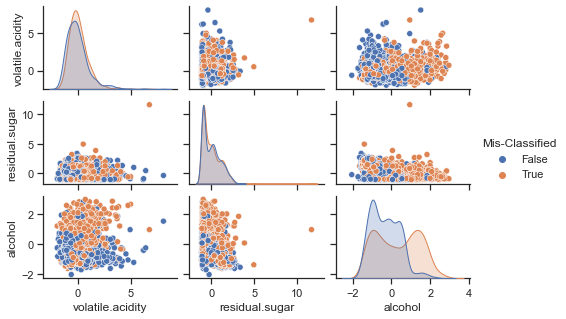

In [28]:
LDA_best_misclass_train.misclass_pairplot()

In [29]:
# testing

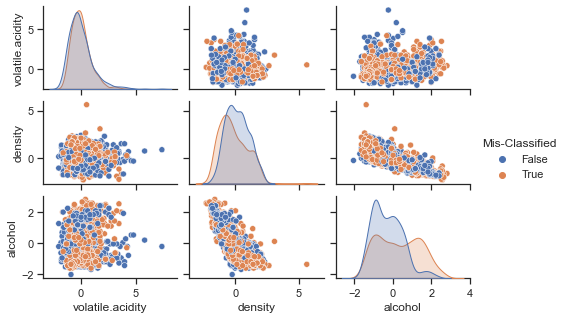

In [30]:
LDA_best_misclass_test.misclass_pairplot()

# (b) Using priors that reflect the observed proportion of wine quality in the training dataset, identify the combination of three features that provide the lowest mis-classification rate. Do the best models differ from when you used flat priors?

In [31]:
LDA_train, LDA_test = three_features_combo(priors = priors_observed)

train_final = pd.DataFrame(LDA_train, columns = ['Combination', 'Misclass_Rate'])
test_final = pd.DataFrame(LDA_test, columns = ['Combination', 'Misclass_Rate'])
train_min = pd.DataFrame(train_final[train_final.Misclass_Rate == train_final.Misclass_Rate.min()]).reset_index()

# training

print(train_min['Combination'][0])
print(train_min['Misclass_Rate'][0])

test_min = pd.DataFrame(test_final[test_final.Misclass_Rate == test_final.Misclass_Rate.min()]).reset_index()

# testing

print(test_min['Combination'][0])
print(test_min['Misclass_Rate'][0])

LDA_best_misclass_train = LDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors = priors_observed)
LDA_best_misclass_test = LDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors = priors_observed)

['volatile.acidity', 'sulphates', 'alcohol', 'wine_quality']
0.2800503461296413
['volatile.acidity', 'residual.sugar', 'alcohol', 'wine_quality']
0.3296511627906977


In [32]:
# training

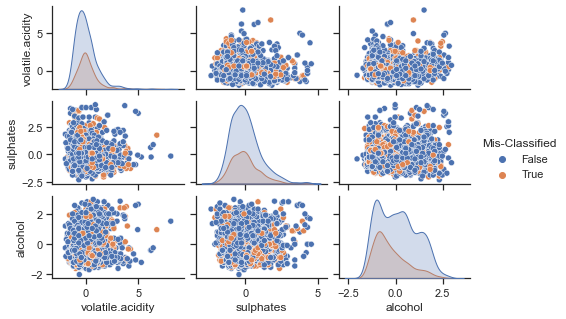

In [33]:
LDA_best_misclass_train.misclass_pairplot()

In [34]:
# testing

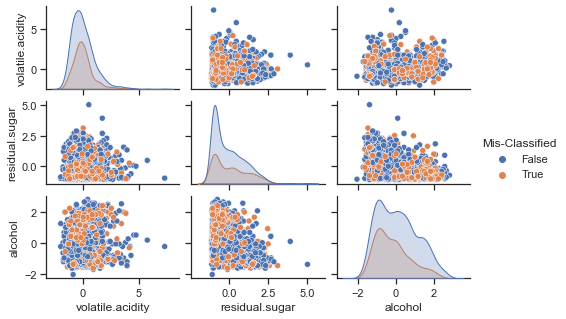

In [35]:
LDA_best_misclass_test.misclass_pairplot()

# Do the best models differ from when you used flat priors?

The best models are different when using flat priors, but the differences are minimal. When employing flat priors, the top-performing training model utilizes volatile acidity, residual sugar, and alcohol as its features. With proportional priors, the best model incorporates volatile acidity, sulphates, and alcohol. In terms of the best testing models, the flat prior model includes volatile acidity, density, and alcohol, while the proportional priors model utilizes volatile acidity, residual sugar, and alcohol.

Only one measure varies between these models and the best model for the flat prior training model aligns with the best model for the proportional priors testing model. Additionally, the misclassification rate is significantly lower for the model employing proportional priors.

# 3. Quadratic Discriminant Analysis (25 Points) Now, fit QDA classifiers (using all 11 continuous features to predict wine quality) under the following scenarios (NOTE: This problem is identical to the previous, except now you are using QDA rather than LDA. Copy-paste your code accordingly.)

In each case, calculate the overall mis-classification rate and present a cross-tabs table showing which categories are being classified correctly vs. incorrectly in your training dataset. (Note, do not present pair-plots here, the dimensionality is too high.)
Next, for each prior, apply your QDA model to the testing dataset, and present the mis-classification rate and cross-tabs.
Discuss the performance of your QDA models under your various choices of priors. How does the performance change when we start testing our models on the testing data?

# (a) Non-informative (flat) priors on wine quality

In [36]:
# QDA Class (code given in example from Professor)

class QDA(LDA):
    def __init__(self, dataset, class_var, priors = None):
        n_class = len(dataset[class_var].unique())
        if priors is None:
            priors = np.repeat(1/n_class, n_class)
        self.priors = np.asarray(priors)
        self.means = dataset.groupby(class_var).mean()
        gb = dataset.groupby(class_var)
        self.sigma = {x: gb.get_group(x).cov() for x in gb.groups}
        self.class_var = class_var
        self.training_data = dataset
    def predict_probs(self, data = None):
        if data is None:
            data = self.training_data
        data_temp = data.drop(self.class_var, axis = 1)
        dens_list = []
        col_names = []
        for ind, row in self.means.iterrows():
            col_names.append(ind)
            dens_list.append(multivariate_normal.pdf(data_temp, mean = np.asarray(row), cov = np.asarray(self.sigma[ind])))
        dens_list = pd.DataFrame(np.transpose(np.vstack(dens_list)),columns= col_names)
        dens_list = dens_list.mul(self.priors, axis=1)
        dens_list = dens_list.div(dens_list.sum(axis=1), axis=0)
        dens_list['True Class'] = data[self.class_var]
        return dens_list 

In [37]:
# default uniform priors
QDA_wine_flat = QDA(wine_training, 'wine_quality')

# misclassification rate of training set
QDA_wine_flat.misclass_rate()

0.5088105726872247

The wine training set misclassification rate is 50.88%.

In [38]:
# cross-tabs table
QDA_wine_flat.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,87,828,90
C,9,799,235
F,4,451,675


In [39]:
# misclassification of testing set
QDA_wine_flat.misclass_rate(data = wine_testing)

0.5186046511627906

The wine testing set misclassification rate is 51.86%.

In [40]:
# cross-tabs table
QDA_wine_flat.misclass_xtabs(data = wine_testing)

True Class,A,C,F
MAP Class,,,
A,58,414,54
C,21,381,197
F,1,205,389


# (b) Priors that reflect the observed proportion of wines at different quality levels.

In [76]:
wine_quality = wine_training['wine_quality'].value_counts(normalize = True) 

In [42]:
priors_observed = [wine_quality[2], wine_quality[0], wine_quality[1] ]
QDA_wine_observed = QDA(wine_training, 'wine_quality', priors_observed)

In [43]:
# misclassification of training set
QDA_wine_observed.misclass_rate()

0.27879169288860917

The wine training set misclassification rate is 27.88%.

In [44]:
# cross-tabs table
QDA_wine_observed.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,20,36,3
C,78,1754,479
F,2,288,518


In [64]:
# misclassification of testing set
QDA_wine_flat.misclass_rate(data = wine_testing)

0.5186046511627906

The wine testing set misclassification rate is 51.86%.

In [65]:
# cross-tabs table
QDA_wine_observed.misclass_xtabs(data = wine_testing)

True Class,A,C,F
MAP Class,,,
A,7,24,1
C,73,842,340
F,0,134,299


# (c) Priors that reflect the notion that most wines are awful, some wines are average, and few wines are good (your choice for specific values.)

In [45]:
QDA_wine_mix = QDA(wine_training, 'wine_quality', [.05, .20, .75])

In [46]:
QDA_wine_mix.misclass_rate()

0.48174952800503457

The wine training set misclassification rate is 48.17%.

In [47]:
QDA_wine_mix.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,52,348,24
C,30,723,104
F,18,1007,872


In [48]:
QDA_wine_mix.misclass_rate(data = wine_testing)

0.44825581395348835

The wine testing set misclassification rate is 44.83%.

In [49]:
QDA_wine_mix.misclass_xtabs(data = wine_testing)

True Class,A,C,F
MAP Class,,,
A,33,171,8
C,33,360,76
F,14,469,556


# (d) Priors that somebody with terrible taste in wine would use (i.e. most wines are good, few wines are bad or average).

In [50]:
QDA_wine_terrible = QDA(wine_training, 'wine_quality', [.85, .10, .05])

In [51]:
QDA_wine_terrible.misclass_rate()

0.6865953429830082

The wine training set misclassification rate is 68.66%.

In [52]:
QDA_wine_terrible.misclass_xtabs()

True Class,A,C,F
MAP Class,,,
A,96,1406,318
C,2,419,201
F,2,253,481


In [53]:
QDA_wine_terrible.misclass_rate(data = wine_testing)

0.672093023255814

The wine testing set misclassification rate is 67.21%.

In [54]:
QDA_wine_terrible.misclass_xtabs(data = wine_testing)

True Class,A,C,F
MAP Class,,,
A,71,677,196
C,9,204,155
F,0,119,289


# Discuss the performance of your QDA models under your various choices of priors. How does the performance change when we start testing our models on the testing data?

Amongst the QDA models, almost all of them demonstrated a misclassifcation rate of over 50%. The priors that reflect the observed proportion of wines at different quality levels performed the best, with a training dataset misclassifcation rate of 27% and a testing dataset misclassification rate of 51%. The priors that somebody with terrible taste in wine would use performed the worst, with respective misclassification rates of 68.66% and 67.21%.

When comparing the QDA data to the LDA results, the misclassification rates for both training and testing data are elevated when using non-informed priors, proportional priors, and good taste priors. Conversely, the misclassification rate is significantly lower for bad taste priors. Despite these variations, proportional priors remain superior in terms of misclassification rates, and the overall ranking from best to worst is preserved. Additionally, when considering the misclassification rate, the testing data exhibits higher values than the training data for non-informed priors and proportional priors, while it is lower for good and bad taste priors.

# 4. (25 Points) Fit QDA models for each combination of 3 features (loop over all combinations of 3 features, there will be 165 combinations). Use flat priors on wine quality.

In [74]:
# loop over all combinations of 3 features, there will be 165 combinations
def QDA_three_features_combo(priors):
    features_combo_2 = [list(x) for x in combinations(wine_training.drop('wine_quality', axis=1), 3)]

    QDA_training_results = []
    QDA_testing_results = []

    # iterate combos 
    for combination in features_combo_2:
        current_columns = combination + ['wine_quality']
        train_three_2 = wine_training[current_columns]
        test_three_2 = wine_testing[current_columns]
        QDA_3 = QDA(train_three_2, 'wine_quality', priors=priors)
        train_misclass = QDA_3.misclass_rate()
        test_misclass = QDA_3.misclass_rate(test_three_2)
        QDA_training_results.append((current_columns, train_misclass))
        QDA_testing_results.append((current_columns, test_misclass))

    return(QDA_training_results, QDA_testing_results)

# (a) For each model, extract the overall miss-classification rate for both the training and the testing dataset. Which combination of three features provides the lowest miss-classification rate for the testing and training datasets? Are they the same or different (between the training/testing)? For the best performing models (for training and testing), using the functions provided, provide pair-plots for mis-classification.

In [75]:
QDA_train, QDA_test = QDA_three_features_combo(priors = flat_priors)
train_final = pd.DataFrame(QDA_train, columns = ['Combination', 'Misclass_Rate'])
test_final = pd.DataFrame(QDA_test, columns = ['Combination', 'Misclass_Rate'])
train_min = pd.DataFrame(train_final[train_final.Misclass_Rate == train_final.Misclass_Rate.min()]).reset_index()

print(train_min['Combination'][0])
print(train_min['Misclass_Rate'][0])

test_min = pd.DataFrame(test_final[test_final.Misclass_Rate == test_final.Misclass_Rate.min()]).reset_index()

print(test_min['Combination'][0])
print(test_min['Misclass_Rate'][0])

QDA_best_misclass_train = QDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors = flat_priors)
QDA_best_misclass_test = QDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors = flat_priors)

['volatile.acidity', 'free.sulfur.dioxide', 'sulphates', 'wine_quality']
0.4269981120201385
['volatile.acidity', 'free.sulfur.dioxide', 'alcohol', 'wine_quality']
0.4511627906976744


The training dataset achieves the lowest misclassification rate when utilizing the features volatile.acidity, free.sulfur.dioxide, and sulphates. Similarly, the testing dataset achieves the lowest misclassification rate when employing volatile.acidity, free.sulfur.dioxide, and alcohol. These feature combinations are consistent with the findings from LDA, with the exception of one differing feature.

# For the best performing models (for training and testing), using the functions provided, provide pair-plots for mis-classification.

In [57]:
# training

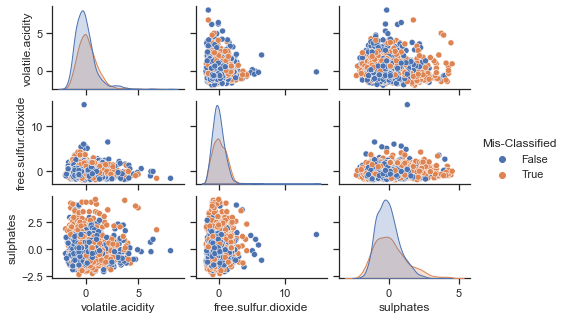

In [58]:
QDA_best_misclass_train.misclass_pairplot()

In [59]:
# testing

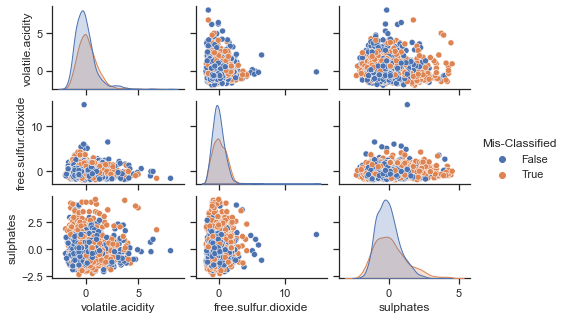

In [60]:
QDA_best_misclass_train.misclass_pairplot()

# (b) Using priors that reflect the observed proportion of wine quality in the training dataset, identify the combination of three features that provide the lowest mis-classification rate. Do the best models differ from when you used flat priors?

In [61]:
QDA_train, QDA_test = QDA_three_features_combo(priors = priors_observed)
train_final = pd.DataFrame(QDA_train, columns = ['Combination', 'Misclass_Rate'])
test_final = pd.DataFrame(QDA_test, columns = ['Combination', 'Misclass_Rate'])

train_min = pd.DataFrame(train_final[train_final.Misclass_Rate == train_final.Misclass_Rate.min()]).reset_index()

print(train_min['Combination'][0])
print(train_min['Misclass_Rate'][0])

test_min = pd.DataFrame(test_final[test_final.Misclass_Rate == test_final.Misclass_Rate.min()]).reset_index()

print(test_min['Combination'][0])
print(test_min['Misclass_Rate'][0])

QDA_best_misclass_train = QDA(wine_training[train_min['Combination'][0]], 'wine_quality', priors = priors_observed)
QDA_best_misclass_test = QDA(wine_testing[test_min['Combination'][0]], 'wine_quality', priors = priors_observed)

['volatile.acidity', 'residual.sugar', 'alcohol', 'wine_quality']
0.27375707992448084
['volatile.acidity', 'residual.sugar', 'alcohol', 'wine_quality']
0.31511627906976747


# Do the best models differ from when you used flat priors?

Yes, the best model differs from when using flat priors. 

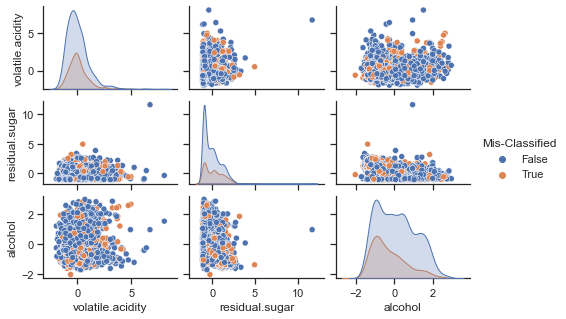

In [62]:
# training

QDA_best_misclass_train.misclass_pairplot()

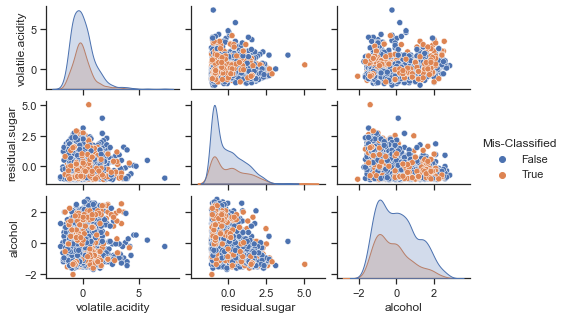

In [63]:
# testing

QDA_best_misclass_test.misclass_pairplot()